In [12]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit
import pandas as pd
import mio
from shapely.geometry import Polygon, Point, LineString
import geopandas as gpd
import random
import pathlib
import rasterio

In [2]:
def bary(ar, P0, P1, P2):
    "take empty array and fill with triangles"
    x0, y0, z0 = P0
    x1, y1, z1 = P1
    x2, y2, z2 = P2
    
    xmin, xmax = min([x0,x1,x2]), max([x0,x1,x2])
    ymin, ymax = min([y0,y1,y2]), max([y0,y1,y2])
    
    det = (y1 -y2)*(x0 - x2) + (x2 - x1)*(y0 - y2)
    if det == 0:
        return
    for y in range(ymin, ymax + 1):
        for x in range(xmin, xmax + 1):
    
            u0 = (y1 - y2)*(x - x2) + (x2 - x1)*(y  - y2)
            l0 = u0 / det
            u1 = (y2 - y0)*(x - x2) + (x0 - x2)*(y  - y2)
            l1 = u1 / det
            l2 = 1 -l0 -l1

            if 0 <= l0 <= 1 and 0 <= l1 <= 1 and 0 <= l2 <= 1:
                z = l0 * z0 + l1 * z1 + l2 * z2
                ar[y, x] = max(ar[y, x], int(z + 0.5))


In [6]:
def make_raster(tri_path, res_tif):
    # read tris
    df = pd.read_csv(tri_path)
    
    # prepare empty array
    xmin = min(df.x0.min(), df.x1.min(), df.x2.min())
    xmax = max(df.x0.max(), df.x1.max(), df.x2.max())
    ymin = min(df.y0.min(), df.y1.min(), df.y2.min())
    ymax = max(df.y0.max(), df.y1.max(), df.y2.max())
    xa = int(xmin)
    ya = int(ymin)
    w = int(xmax - xmin) + 2
    h = int(ymax - ymin) + 2
    xa, ya, w, h
    ar = np.zeros((h, w), dtype=int)
    
    # fill array
    for ind, row in df.iterrows():
        P0 = int(row.x0 - xa), int(row.y0 - ya), int(row.z0 + 0.5)
        P1 = int(row.x1 - xa), int(row.y1 - ya), int(row.z1 + 0.5)
        P2 = int(row.x2 - xa), int(row.y2 - ya), int(row.z2 + 0.5)
        bary(ar, P0, P1, P2)
        
    # make geo tiff
    ra = pd.DataFrame(ar, columns= range(xa, xa+ w), index=range(ya, ya + h))
    ra = ra.sort_index(ascending=False)
    mio.write_raster(ra.astype('uint16'), res_tif)

In [7]:
tris = pathlib.Path(r"C:\loc\_SwissBuildings\tris").glob("*.tri")
tris = list(tris)

In [8]:
%%time
iall = len(tris)
for i, tri in enumerate(tris):
    mio.show_perc(i, iall, 10)
    res = f'tif/{tri.stem}.tif'
    make_raster(tri, res)

0.0% 0.31% 0.62% 0.93% 1.24% 1.55% 1.86% 2.17% 2.48% 2.79% 3.1% 3.42% 3.73% 4.04% 4.35% 4.66% 4.97% 5.28% 5.59% 5.9% 6.21% 6.52% 6.83% 7.14% 7.45% 7.76% 8.07% 8.38% 8.69% 9.0% 9.31% 9.62% 9.93% 10.25% 10.56% 10.87% 11.18% 11.49% 11.8% 12.11% 12.42% 12.73% 13.04% 13.35% 13.66% 13.97% 14.28% 14.59% 14.9% 15.21% 15.52% 15.83% 16.14% 16.45% 16.76% 17.08% 17.39% 17.7% 18.01% 18.32% 18.63% 18.94% 19.25% 19.56% 19.87% 20.18% 20.49% 20.8% 21.11% 21.42% 21.73% 22.04% 22.35% 22.66% 22.97% 23.28% 23.6% 23.91% 24.22% 24.53% 24.84% 25.15% 25.46% 25.77% 26.08% 26.39% 26.7% 27.01% 27.32% 27.63% 27.94% 28.25% 28.56% 28.87% 29.18% 29.49% 29.8% 30.11% 30.43% 30.74% 31.05% 31.36% 31.67% 31.98% 32.29% 32.6% 32.91% 33.22% 33.53% 33.84% 34.15% 34.46% 34.77% 35.08% 35.39% 35.7% 36.01% 36.32% 36.63% 36.95% 37.26% 37.57% 37.88% 38.19% 38.5% 38.81% 39.12% 39.43% 39.74% 40.05% 40.36% 40.67% 40.98% 41.29% 41.6% 41.91% 42.22% 42.53% 42.84% 43.15% 43.46% 43.78% 44.09% 44.4% 44.71% 45.02% 45.33% 45.64% 45.95% 46.26%

In [ ]:
# 9h

In [22]:
# make grid
tifs = list(pathlib.Path('tif').glob('*.tif'))
geoms = []
names = []
for i, tif in enumerate(tifs):
    mio.show_perc(i, len(tifs), 100)
    r = rasterio.open(tif)
    x0, y0, x1, y1 = r.bounds
    p = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
    names.append(tif.stem)
    geoms.append(p)
    r.close()

0.0% 3.1% 6.21% 9.31% 12.42% 15.52% 18.63% 21.73% 24.84% 27.94% 31.05% 34.15% 37.26% 40.36% 43.46% 46.57% 49.67% 52.78% 55.88% 58.99% 62.09% 65.2% 68.3% 71.41% 74.51% 77.62% 80.72% 83.82% 86.93% 90.03% 93.14% 96.24% 99.35% 

In [24]:
gdf = gpd.GeoDataFrame({'name':names}, geometry= geoms)
mio.write_tab(gdf, 'tif/_grid.tab')

3221 row(s) written to mapinfo file.


<AxesSubplot:>

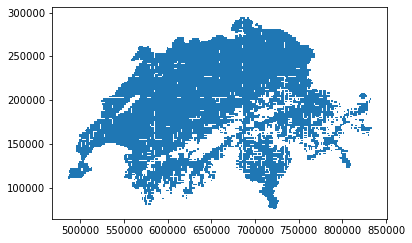

In [25]:
gdf.plot()